File descriptions
sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
sample_submission.csv - a sample submission file in the correct format.
items.csv - supplemental information about the items/products.
item_categories.csv  - supplemental information about the items categories.
shops.csv- supplemental information about the shops.
Data fields
ID - an Id that represents a (Shop, Item) tuple within the test set
shop_id - unique identifier of a shop
item_id - unique identifier of a product
item_category_id - unique identifier of item category
item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
item_price - current price of an item
date - date in format dd/mm/yyyy
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
item_name - name of item
shop_name - name of shop
item_category_name - name of item category

In [1]:
import numpy as np 
import pandas as pd 
import random as rd 
import datetime 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf  
from statsmodels.tsa.stattools import adfuller as ADF  
from statsmodels.graphics.tsaplots import plot_pacf    
from statsmodels.stats.diagnostic import acorr_ljungbox    

In [3]:
sales = pd.read_csv('/Users/wandawu/Desktop/predict sales/sales_train.csv')
item_cat=pd.read_csv('/Users/wandawu/Desktop/predict sales/item_categories.csv')
item=pd.read_csv('/Users/wandawu/Desktop/predict sales/items.csv')
sample=pd.read_csv('/Users/wandawu/Desktop/predict sales/sample_submission.csv')
shops=pd.read_csv('/Users/wandawu/Desktop/predict sales/shops.csv')
test=pd.read_csv('/Users/wandawu/Desktop/predict sales/test.csv')

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [6]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


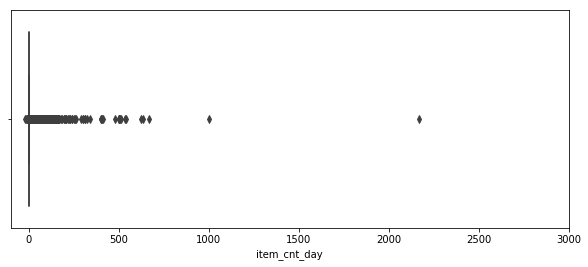

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)

In [8]:
sales = sales[sales.item_cnt_day<1001]

date_block_num
0     131479.0
1     128090.0
2     147142.0
3     107190.0
4     106970.0
5     125381.0
6     116966.0
7     125291.0
8     133332.0
9     127541.0
10    130009.0
11    183342.0
12    116899.0
13    109687.0
14    115297.0
15     96556.0
16     97790.0
17     97429.0
18     91280.0
19    102721.0
20     99208.0
21    107422.0
22    117845.0
23    168755.0
24    110971.0
25     84198.0
26     82014.0
27     77827.0
28     72295.0
29     64114.0
30     63187.0
31     66079.0
32     72843.0
33     68887.0
Name: item_cnt_day, dtype: float64

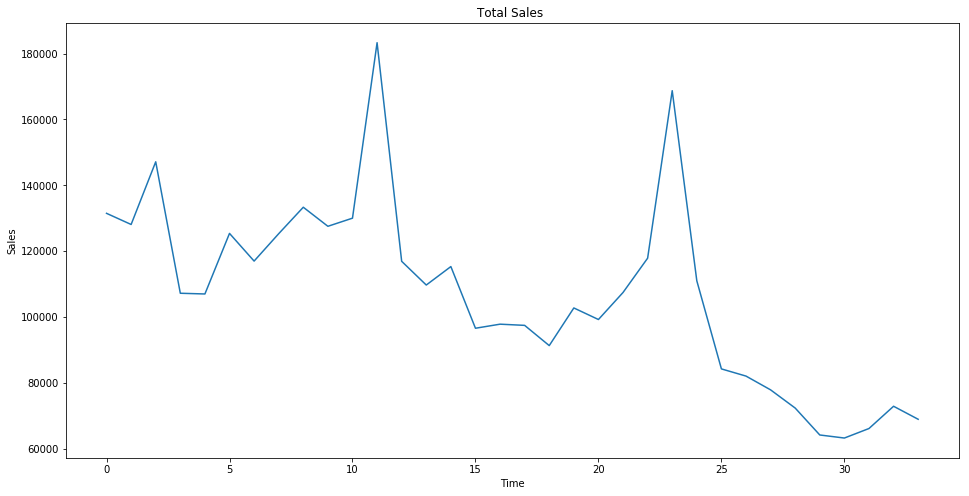

In [9]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales ')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
ts

There are 2 peak point at time=11 and time=23. The reason may be that people will buy more item at the christmas month.

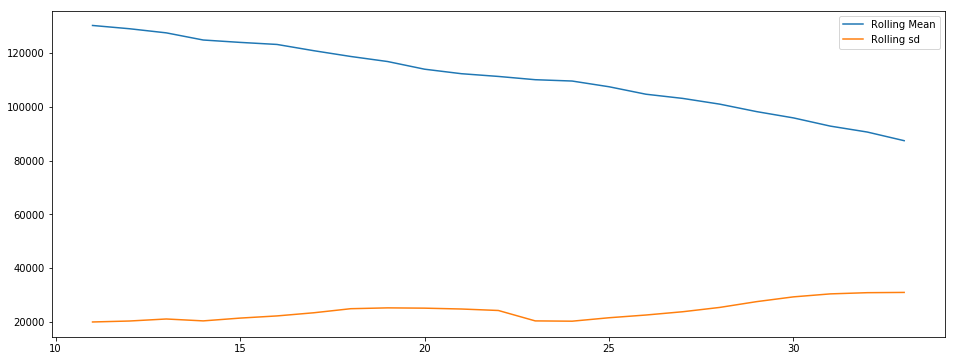

In [10]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()


we can conclude that there is a obvious'seasonality' and decreasing sale trend.

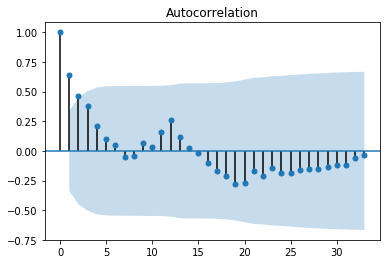

In [11]:
# we need check the stationarity in the next step
plot_acf(ts).show()

In [12]:
print(u'adf result：', ADF(ts))

adf result： (-2.368990987472559, 0.15068038840970682, 0, 33, {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}, 531.042072348383)


pvalue>>0.1 we can conclude that ts is unstationary

In [13]:
# Then we can do de-trend

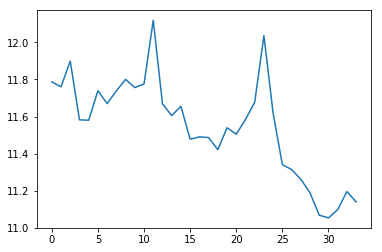

In [14]:
ts_log=np.log(ts)
plt.plot(ts_log)


In [15]:
ts_log

date_block_num
0     11.786602
1     11.760488
2     11.899153
3     11.582358
4     11.580304
5     11.739112
6     11.669639
7     11.738394
8     11.800598
9     11.756193
10    11.775359
11    12.119109
12    11.669066
13    11.605386
14    11.655267
15    11.477878
16    11.490578
17    11.486879
18    11.421687
19    11.539772
20    11.504974
21    11.584520
22    11.677125
23    12.036203
24    11.617024
25    11.340926
26    11.314645
27    11.262244
28    11.188510
29    11.068418
30    11.053854
31    11.098606
32    11.196062
33    11.140223
Name: item_cnt_day, dtype: float64

[]

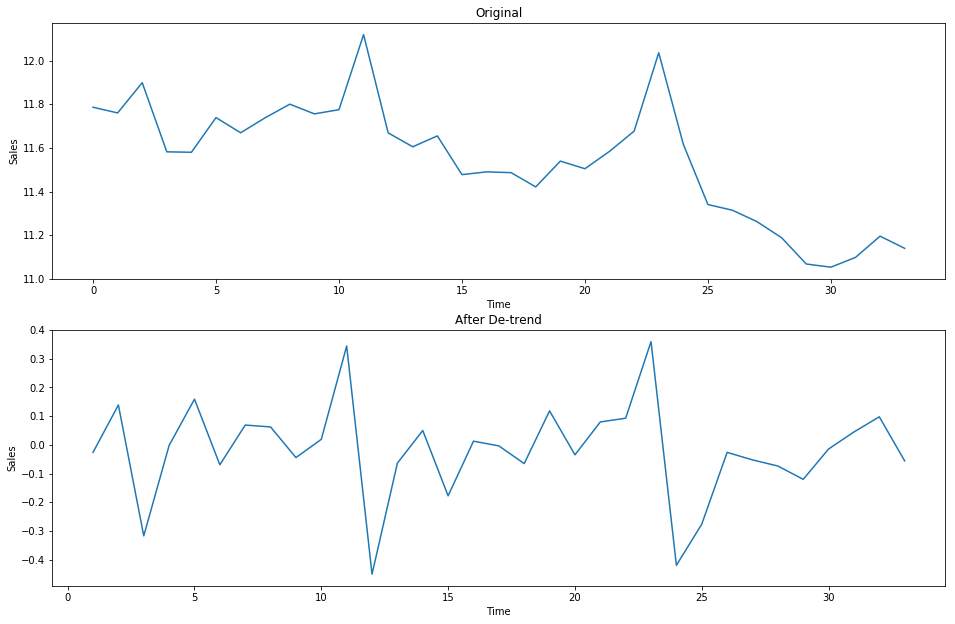

In [54]:
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts_log)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
D_ts=ts_log.diff().dropna()
plt.plot(D_ts)
plt.plot()



In [55]:
D_ts


date_block_num
1    -0.026114
2     0.138665
3    -0.316795
4    -0.002055
5     0.158809
6    -0.069474
7     0.068756
8     0.062203
9    -0.044404
10    0.019166
11    0.343750
12   -0.450043
13   -0.063679
14    0.049881
15   -0.177388
16    0.012699
17   -0.003698
18   -0.065192
19    0.118085
20   -0.034798
21    0.079546
22    0.092605
23    0.359078
24   -0.419179
25   -0.276098
26   -0.026281
27   -0.052402
28   -0.073733
29   -0.120092
30   -0.014564
31    0.044752
32    0.097455
33   -0.055839
Name: item_cnt_day, dtype: float64

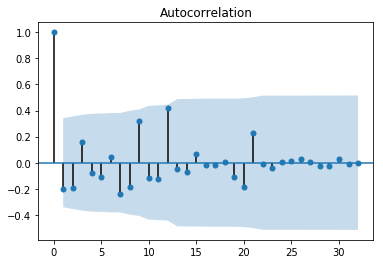

In [56]:
plot_acf(D_ts).show()


adf result： (-6.693976573141017, 4.04311110347798e-09, 10, 22, {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}, -30.745985516517635)


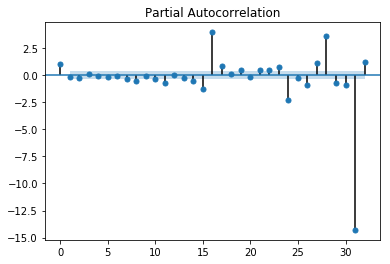

In [57]:
plot_pacf(D_ts).show()
print(u'adf result：', ADF(D_ts))


pvalue<0.05 trend is stationary now.

In [20]:
print(u'white noise result：', acorr_ljungbox(ts, lags=1))

white noise result： (array([15.0628617]), array([0.00010399]))


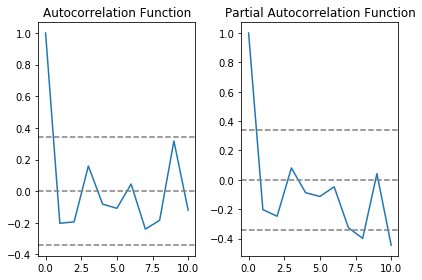

In [21]:
lag_acf = acf(D_ts, nlags=10)
lag_pacf = pacf(D_ts, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(D_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(D_ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(D_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(D_ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


p=q=4

Text(0.5,1,'RSS: 0.8537')

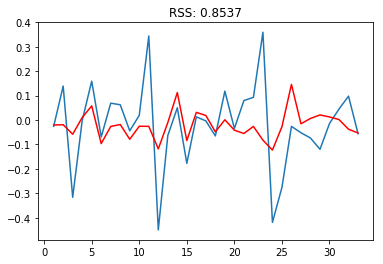

In [36]:
# AR model
model = ARIMA(ts_log, order=(4, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(D_ts)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-D_ts)**2))


Text(0.5,1,'RSS: 0.7784')

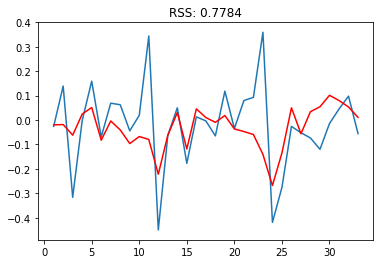

In [38]:
# MA model
model = ARIMA(ts_log, order=(0, 1, 4))  
results_MA = model.fit(disp=-1)  
plt.plot(D_ts)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-D_ts)**2))

Text(0.5,1,'RSS: 0.7383')

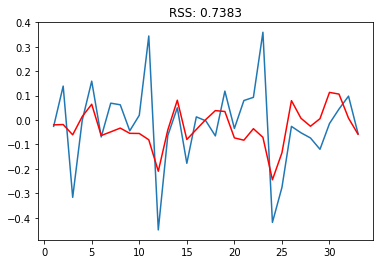

In [80]:
#ARIMA
model = ARIMA(ts_log, order=(4, 1, 4))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(D_ts)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-D_ts)**2))

According to RSS, ARIMA has better performance

In [81]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date_block_num
1   -0.020011
2   -0.018755
3   -0.060696
4    0.013839
5    0.064286
dtype: float64

start from 1 not 0

In [82]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date_block_num
1   -0.020011
2   -0.038766
3   -0.099462
4   -0.085623
5   -0.021337
dtype: float64

In [83]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

predictions_ARIMA_log.head()

date_block_num
0    11.786602
1    11.766591
2    11.747836
3    11.687140
4    11.700980
dtype: float64

date_block_num
0     131479.000000
1     128874.082194
2     126479.622555
3     119031.142830
4     120689.878454
5     128703.330171
6     120757.532586
7     115015.926114
8     111251.095532
9     105330.979220
10     99665.777594
11     91902.909689
12     74507.475652
13     71523.123806
14     77545.480174
15     71591.054422
16     68861.469024
17     69004.971911
18     71702.395716
19     74235.762954
20     68989.239592
21     63509.619209
22     61279.930204
23     57073.557485
24     44676.917155
25     39061.440750
26     42276.989224
27     42577.784132
28     41497.544998
29     41718.128804
30     46702.087006
31     51921.610866
32     52304.179223
33     49336.372480
dtype: float64

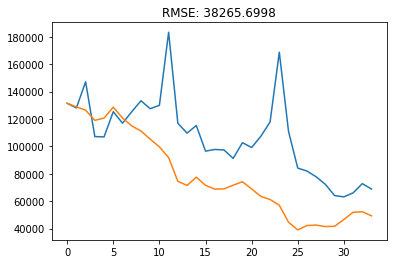

In [84]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
predictions_ARIMA

I'm not statisfied with the accuracy of the prediction. Let's try Facebook Prophet.

In [89]:
#Prophet
!pip install pystan

     |████████████████████████████████| 37.4MB 42.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [93]:
!conda install -c conda-forge fbprophet --yes

Solving environment: done

## Package Plan ##

  environment location: /anaconda3

  added / updated specs: 
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    llvm-4.0.1                 |       hc748206_0       136.7 MB  conda-forge
    clang-4.0.1                |       h662ec87_0        73.7 MB
    llvm-lto-tapi-4.0.1        |       h6701bc3_0        11.7 MB  conda-forge
    certifi-2018.4.16          |           py36_0         142 KB  conda-forge
    clangxx-4.0.1              |       hc9b4283_0          10 KB
    ld64-274.2                 |       h7c2db76_0         2.6 MB  conda-forge
    clangxx_osx-64-4.0.1       |      h22b1bf0_16         140 KB
    holidays-0.9.10            |             py_0          36 KB  conda-forge
    clang_osx-64-4.0.1         |      h1ce6c1d_16         140 KB
    fbprophet-0.4.post2        |   py36h0a44026_0         618 KB  conda-forge
 

In [102]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()

ts.columns=['ds','y']
ts.head()

,ds,y
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [103]:
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [104]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,81652.037241,78252.023515,84992.047131
35,2015-12-01,127205.169684,123763.051661,130685.751626
36,2016-01-01,76574.163363,73033.376901,80016.934067
37,2016-02-01,40215.088442,37031.912807,43802.874750
38,2016-03-01,77996.552811,74707.996571,81436.118918


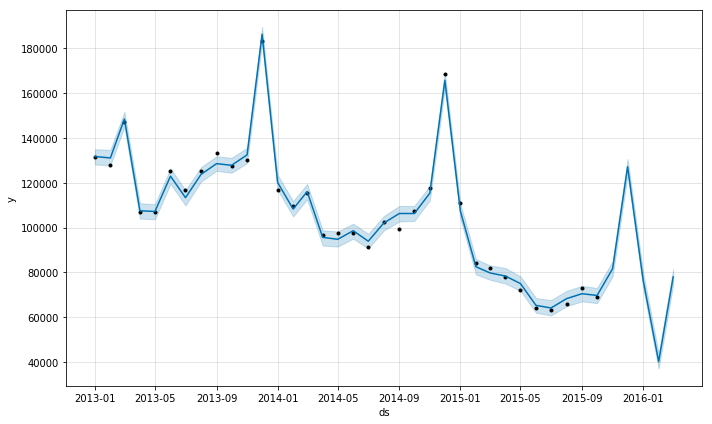

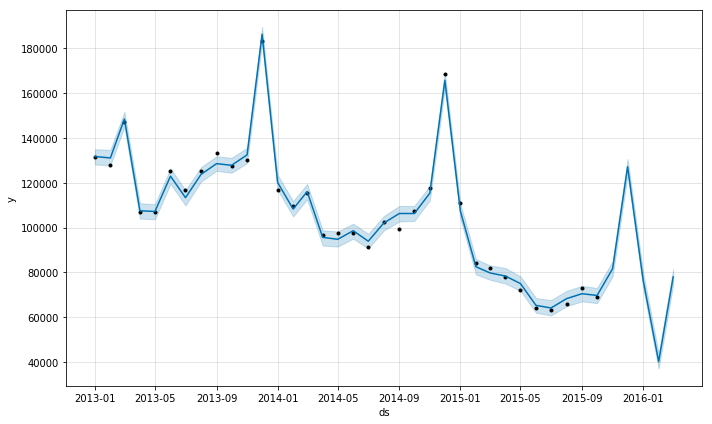

In [105]:
model.plot(forecast)

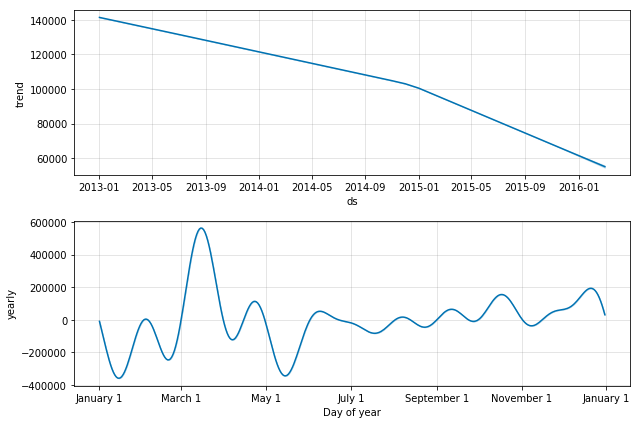

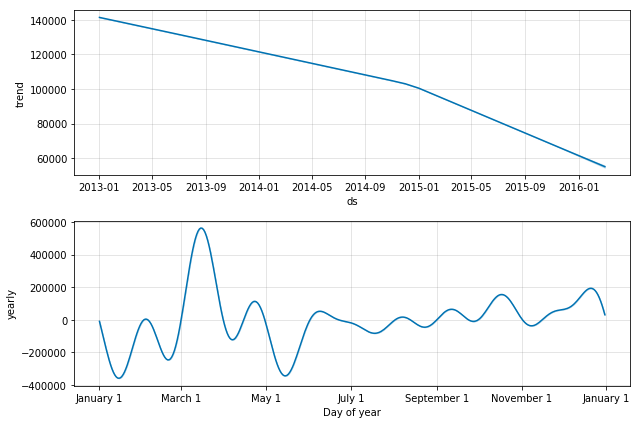

In [106]:
model.plot_components(forecast)

!!!! amazing